In [183]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Tabular Only Baseline

In [184]:
import fastai
from fastai import *
from fastai.callbacks import SaveModelCallback
from fastai.tabular import *
from pathlib import Path
from cape_core.data import *
from cape_core.utils import *

In [185]:
PATH = Path.cwd()
PATH.ls()

[PosixPath('/home/tc256760/Documents/Tabular_image_model/Sample Models/feat_xr34_512_zoom20_256'),
 PosixPath('/home/tc256760/Documents/Tabular_image_model/Sample Models/zoom15'),
 PosixPath('/home/tc256760/Documents/Tabular_image_model/Sample Models/tabular_feature_sample-Copy1.ipynb'),
 PosixPath('/home/tc256760/Documents/Tabular_image_model/Sample Models/labels_sample'),
 PosixPath('/home/tc256760/Documents/Tabular_image_model/Sample Models/feat_xr34_512_zoom15_256'),
 PosixPath('/home/tc256760/Documents/Tabular_image_model/Sample Models/train_classifier.py'),
 PosixPath('/home/tc256760/Documents/Tabular_image_model/Sample Models/tabular_sample_baseline.ipynb'),
 PosixPath('/home/tc256760/Documents/Tabular_image_model/Sample Models/tabular_feature_sample.ipynb'),
 PosixPath('/home/tc256760/Documents/Tabular_image_model/Sample Models/.ipynb_checkpoints'),
 PosixPath('/home/tc256760/Documents/Tabular_image_model/Sample Models/classifier_sample-refactor.ipynb'),
 PosixPath('/home/tc256

# Model

In [186]:
data = get_data(PATH).drop('index', axis=1).reset_index(drop=True); data.head()
# data = data[data.sgr_id>0].reset_index(drop=True)

,p_ab_rs_band,p_90_rs_band,dont_use_rs,p_ab_cs_band,p_90_cs_band,dont_use_cs,p_ab_3party_band,p_90_3party_band,dont_use_3party,prop_aursrc,...,cad_id,prop_id,asatdate,prop_titledeedtype,estate_id,sgr_id,suburb_id,trf_purchprice,prop_munvalinfl,train
0,8,10,0,4,7,0,0,0,1,9,...,6905651,11944540,2017-04-15,FH,0.0,0,9834.0,1550000.0,0.0,True
1,8,9,0,6,8,0,0,0,1,7,...,4669236,11360646,2017-09-11,FH,0.0,0,3496.0,900000.0,0.0,True
2,8,8,0,7,10,0,0,0,1,17,...,1057686,11435648,2017-02-08,FH,0.0,0,48.0,1995000.0,0.0,True
3,9,10,0,7,8,0,0,0,1,17,...,5487873,15736748,2017-11-07,FH,0.0,0,5545.0,900000.0,0.0,True
4,8,8,0,6,8,0,0,0,1,7,...,168364,9485339,2017-10-17,FH,0.0,0,4339.0,1230000.0,939320.0,True


In [187]:
cat_names = ['prop_aursrc','prop_modseg','asatMonth','prop_lastpurchMonth',
             'estate_id','prop_munvalYear','prop_lastpurchYear','dont_use_rs','asatElapsed','p_90_cs_band',
            'prop_bedrooms','date_3partyYear','asatYear','p_ab_final_3party_band','p_90_rs_band','p_90_3party_band',
             'p_ab_rs_band','date_rsYear','p_90_final_3party_band','dont_use_cs','prop_bathrooms','dont_use_3party',
            'p_ab_cs_band','p_ab_3party_band','munic_id','suburb_id']
cont_names = ['pct_offprops_cdn',
             'prop_munvalinfl',
             'prop_munval',
             'prop_lastpurchpriceinfl',
             'prop_firstlistingElapsedMonthsToDate',
             'prop_minlistingprice',
             'area_volotprecent',
             'distancemtoairportint',
             'predval_cs',
             'x',
             'predval_3party',
             'prop_recentotp',
             'estateschemedensity',
             'prop_aur',
             'area_maxlistingrecent',
             'cad_metersfromwater',
             'area_minlistingrecent',            
             'area_avglistingvaluerecent',
             'prop_age',
             'predval_final_3party',
             'distancemtolargeretailcentre',
             'area_avgotprecent',
             'y',        
             'predval_rs',
             'cad_metersfromcoast',
             'prop_recentotpElapsedMonthsToDate',
             'slope',   
             'cad_sqm',
             'distancemtomediumretailcentre']

In [188]:
dep_var='trf_purchprice'
procs = [FillMissing, Categorify, Normalize]
max_log_y = np.log(np.max(data[dep_var])*1.2)
y_range = torch.tensor([12, max_log_y], device=defaults.device); y_range

tensor([12.0000, 15.6073], device='cuda:0')

In [189]:
df = data[cont_names+cat_names+[dep_var]]

In [190]:
val_idxs = data[~data['train']].index

In [191]:
val_idxs

Int64Index([80000, 80001, 80002, 80003, 80004, 80005, 80006, 80007, 80008,
            80009,
            ...
            99990, 99991, 99992, 99993, 99994, 99995, 99996, 99997, 99998,
            99999],
           dtype='int64', length=20000)

In [192]:
df.shape

(100000, 56)

In [193]:
# cat_names = ['prop_lastpurchYear',
#             'prop_bedrooms',
#              'prop_bathrooms']
# cont_names = ['prop_aur',
#              'prop_age']

tdata = TabularList.from_df(df, 
                            procs=procs, 
                            cat_names=cat_names, 
                            cont_names=cont_names).split_by_idx(val_idxs)

In [194]:
#this line takes forever!
tdata = tdata.label_from_df(cols=dep_var,label_cls=FloatList, log=True)
tdata = tdata.databunch(bs=512, num_workers=6)

In [195]:
x,y = tdata.one_batch()

In [196]:
y.shape

torch.Size([512])

# Train

In [197]:
tlearn = tabular_learner(tdata, 
                         layers= [1000, 500],  
                         y_range=y_range, 
                         emb_drop=0.1,
                         loss_func=L1Flat(),
                         metrics=[exp_rmspe, exp_rmse, r2_score]
                        ).to_fp16(clip=2)

In [198]:
tlearn.loss_func

FlattenedLoss of L1Loss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


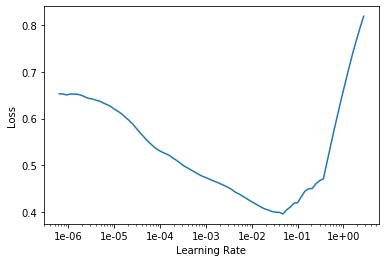

In [199]:
tlearn.lr_find(); tlearn.recorder.plot()

In [200]:
tlearn.fit_one_cycle(12, 
                     1e-3, 
                     callbacks=[SaveModelCallback(tlearn, monitor='exp_rmspe', mode='min', name='best_tabular')])

epoch,train_loss,valid_loss,exp_rmspe,exp_rmse,r2_score,time
0,0.207144,0.190958,0.312442,419906.593750,0.790845,00:03
1,0.183182,0.187608,0.358556,413941.562500,0.797778,00:03
2,0.164364,0.153290,0.304415,367269.937500,0.844538,00:03
3,0.152596,0.149660,0.272378,352915.093750,0.856347,00:03
4,0.142144,0.159175,0.313392,355054.187500,0.841317,00:03
5,0.135143,0.164289,0.306221,370836.718750,0.836814,00:03
6,0.126349,0.183512,0.357470,396891.906250,0.795769,00:03
7,0.120434,0.192550,0.352384,389430.968750,0.789071,00:03
8,0.110975,0.155257,0.301722,350796.437500,0.842860,00:03
9,0.106822,0.158044,0.308816,355594.250000,0.839914,00:03


Better model found at epoch 0 with exp_rmspe value: 0.31244200468063354.
Better model found at epoch 2 with exp_rmspe value: 0.30441534519195557.
Better model found at epoch 3 with exp_rmspe value: 0.27237769961357117.


In [201]:
tlearn.load('best_tabular');

In [202]:
p, t = tlearn.get_preds(DatasetType.Valid)

In [203]:
print_stats(p,t)


RMSE (log y): 0.22606928646564484
RMSE : 354812.59375
RMSPE (log y): 0.016295624896883965
RMSPE: 0.2760637402534485

Data size : (20000,)
Performance Accuracy (A: Within 10%, B: Within 20%, etc)
A    0.50305
B    0.27120
C    0.10660
D    0.05190
E    0.06725
dtype: float64

Data Set size : (20000,)
Performance Accuracy
1: % Error < 20%    0.77425
2: % Error > 20%    0.22575
dtype: float64

Summary:
RMSE : 354812.59375
RMSPE: 0.2760637402534485
%A: 0.50305
%AB: 0.77425
Proportion Under Valuations: 0.54715
